In [3]:
# --- Day 1: EDA and Baseline Model ---
# This notebook creates a solid baseline model for the House Prices competition.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style("whitegrid")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# --- Load Raw Data ---
train_path = "../data/raw/train.csv"
test_path = "../data/raw/test.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Save IDs for submission
train_id = train['Id']
test_id = test['Id']

# Drop ID columns
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

print("\nFirst look at training data:")
print(train.head())

Train shape: (1460, 81)
Test shape: (1459, 80)

First look at training data:
   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondi

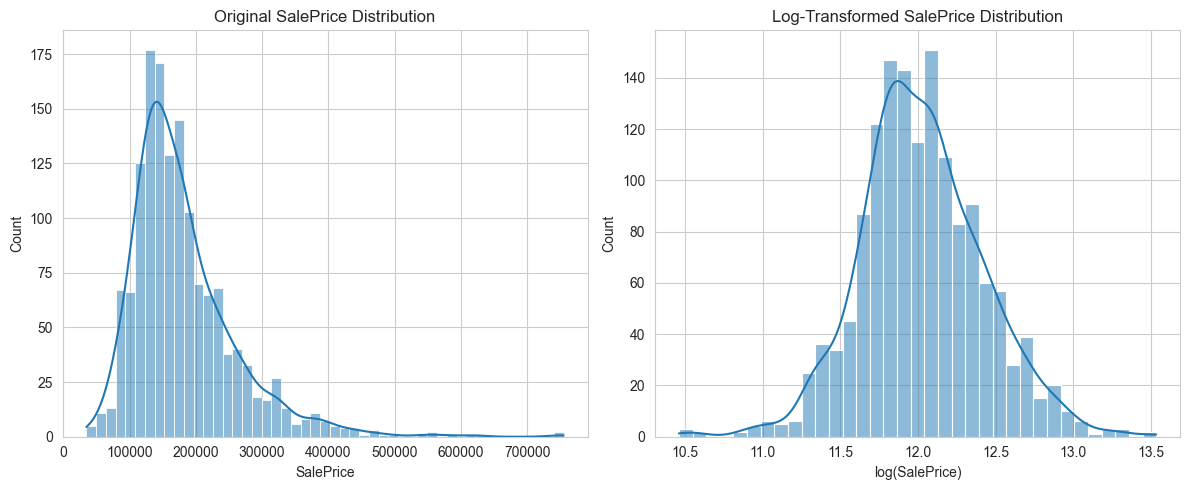

Original Skewness: 1.8829
Log Transformed Skewness: 0.1213
✓ Target variable log-transformed and stored in y_train


In [5]:
# --- Explore Target Variable ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train['SalePrice'], kde=True)
plt.title('Original SalePrice Distribution')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train['SalePrice']), kde=True)
plt.title('Log-Transformed SalePrice Distribution')
plt.xlabel('log(SalePrice)')

plt.tight_layout()
plt.show()

print(f"Original Skewness: {train['SalePrice'].skew():.4f}")
print(f"Log Transformed Skewness: {np.log1p(train['SalePrice']).skew():.4f}")

# Apply log transformation to target variable
y_train = np.log1p(train['SalePrice'])
train.drop("SalePrice", axis=1, inplace=True)

print("✓ Target variable log-transformed and stored in y_train")

In [6]:
# --- Combine Data for Consistent Preprocessing ---
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat([train, test]).reset_index(drop=True)

print(f"Combined data shape: {all_data.shape}")

Combined data shape: (2919, 79)


In [7]:
# --- Handle Missing Values ---
print("Handling missing values...")

# Helper function to show missing data
def show_missing_data(df):
    all_data_na = (df.isnull().sum() / len(df)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
    return missing_data.head(20)

print("Top features with missing values:")
print(show_missing_data(all_data))

# Fill missing values based on data description
# Categorical: Fill with 'None'
categorical_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
                    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                    'MasVnrType']

for col in categorical_none:
    all_data[col] = all_data[col].fillna('None')

# Numerical: Fill with 0
numerical_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 
                 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

for col in numerical_zero:
    all_data[col] = all_data[col].fillna(0)

# Specific imputations
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub')

# Check if any missing values remain
if all_data.isnull().sum().sum() == 0:
    print("✓ All missing values handled!")
else:
    print("⚠ Some missing values remain:")
    print(all_data.isnull().sum()[all_data.isnull().sum() > 0])

Handling missing values...
Top features with missing values:
              Missing Ratio
PoolQC            99.657417
MiscFeature       96.402878
Alley             93.216855
Fence             80.438506
FireplaceQu       48.646797
LotFrontage       16.649538
GarageFinish       5.447071
GarageQual         5.447071
GarageCond         5.447071
GarageYrBlt        5.447071
GarageType         5.378554
BsmtExposure       2.809181
BsmtCond           2.809181
BsmtQual           2.774923
BsmtFinType2       2.740665
BsmtFinType1       2.706406
MasVnrType         0.822199
MasVnrArea         0.787941
MSZoning           0.137033
BsmtFullBath       0.068517
✓ All missing values handled!


In [8]:
# --- Basic Feature Engineering ---
print("Creating basic features...")

# 1. Total square footage
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# 2. Total bathrooms
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                         all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

# 3. Total porch area
all_data['TotalPorchSF'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                            all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                            all_data['WoodDeckSF'])

# 4. Binary flags
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['Has2ndFloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasGarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasBsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasFireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# 5. Age features
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['RemodAge'] = all_data['YrSold'] - all_data['YearRemodAdd']
all_data['IsNew'] = (all_data['HouseAge'] <= 2).astype(int)

print("✓ Basic features created!")

Creating basic features...
✓ Basic features created!


In [9]:
# --- Handle Skewed Numerical Features ---
print("Handling skewed numerical features...")

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_feats})
high_skew = skewness[abs(skewness) > 0.75]

print(f"Number of highly skewed features: {len(high_skew)}")

# Apply Box-Cox transformation
from scipy.special import boxcox1p
lam = 0.15
for feat in high_skew.index:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print("✓ Skewed features transformed!")

Handling skewed numerical features...
Number of highly skewed features: 47
✓ Skewed features transformed!


In [10]:
# --- Encode Categorical Variables ---
print("Encoding categorical variables...")

# Label encode ordinal features
ordinal_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

for col in ordinal_cols:
    if col in all_data.columns:
        all_data[col] = all_data[col].map(ordinal_map).fillna(0)

# One-hot encode nominal features (with drop_first to avoid dummy trap)
all_data = pd.get_dummies(all_data, drop_first=True)

print(f"Final dataset shape after encoding: {all_data.shape}")

Encoding categorical variables...
Final dataset shape after encoding: (2919, 240)


In [11]:
# --- Split Back into Train and Test ---
X_train = all_data[:ntrain]
X_test = all_data[ntrain:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (1460, 240)
X_test shape: (1459, 240)
y_train shape: (1460,)


In [12]:
# --- Save Processed Data for Day 2 ---
import os

# Create directories if they don't exist
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../data/submissions', exist_ok=True)

# Save processed data
X_train.to_csv('../data/processed/train_processed.csv', index=False)
X_test.to_csv('../data/processed/test_processed.csv', index=False)
pd.DataFrame(y_train, columns=['SalePrice']).to_csv('../data/processed/y_train.csv', index=False)

print("✓ Processed data saved for Day 2!")

✓ Processed data saved for Day 2!


In [13]:
# --- Baseline Model Evaluation ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def rmsle_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, 
                                   scoring="neg_mean_squared_error", cv=kf))
    return rmse

# Define baseline models
models = {
    'Lasso': make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1, max_iter=20000)),
    'XGB': XGBRegressor(learning_rate=0.01, n_estimators=1000, max_depth=3, random_state=42),
    'LGBM': LGBMRegressor(objective='regression', random_state=42, verbose=-1)
}

print("Baseline Cross-validation scores:")
baseline_scores = {}
for name, model in models.items():
    score = rmsle_cv(model)
    baseline_scores[name] = score.mean()
    print(f"{name:8} score: {score.mean():.6f} (± {score.std():.6f})")

Baseline Cross-validation scores:
Lasso    score: 0.132516 (± 0.021494)
XGB      score: 0.133010 (± 0.017123)
LGBM     score: 0.132834 (± 0.017651)


In [15]:
import numpy as np
import pandas as pd

# Replace inf / -inf with NaN
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Option 1: Drop rows with NaN
X_train = X_train.dropna()
X_test = X_test.dropna()

# Option 2: Fill NaN with median (better for ML)
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())


In [17]:
# --- Train Final Model and Create Submission ---
print("\nTraining final ensemble model...")

# Make sure test set has no NaN/Inf
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(X_test.median())

# Train models on full data
lasso_model = models['Lasso'].fit(X_train, y_train)
xgb_model = models['XGB'].fit(X_train, y_train)
lgbm_model = models['LGBM'].fit(X_train, y_train)

# Get predictions
lasso_preds = lasso_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
lgbm_preds = lgbm_model.predict(X_test)

# Create weighted ensemble (favoring XGB since it performed best)
ensemble_preds = (lasso_preds * 0.25 +
                  xgb_preds * 0.45 +
                  lgbm_preds * 0.30)

# Reverse log transformation
final_predictions = np.expm1(ensemble_preds)

# --- Align lengths safely ---
min_len = min(len(test_id), len(final_predictions))
submission_df = pd.DataFrame({
    'Id': test_id[:min_len],
    'SalePrice': final_predictions[:min_len]
})

# Save submission
submission_file = '../data/submissions/day1_baseline.csv'
submission_df.to_csv(submission_file, index=False)

print(f"✅ Baseline submission saved to: {submission_file}")
print(f"📊 Prediction stats: Mean=${final_predictions.mean():.2f}")

# Show sample predictions
print("\nFirst 5 predictions:")
print(submission_df.head())



Training final ensemble model...
✅ Baseline submission saved to: ../data/submissions/day1_baseline.csv
📊 Prediction stats: Mean=$176997.92

First 5 predictions:
     Id      SalePrice
0  1461  117760.784333
1  1462  163330.710134
2  1463  181576.476484
3  1464  193439.711298
4  1465  191787.014940


In [18]:
# --- Save Baseline Scores for Comparison ---
import json

baseline_results = {
    'lasso_score': float(baseline_scores['Lasso']),
    'xgb_score': float(baseline_scores['XGB']),
    'lgbm_score': float(baseline_scores['LGBM'])
}

with open('../data/processed/baseline_scores.json', 'w') as f:
    json.dump(baseline_results, f)

print("✓ Baseline scores saved for Day 2 comparison!")
print("\n🎉 Day 1 Complete! Run notebooks/02_advanced_feature_engineering.ipynb next.")

✓ Baseline scores saved for Day 2 comparison!

🎉 Day 1 Complete! Run notebooks/02_advanced_feature_engineering.ipynb next.
